In [69]:
import datetime
import numpy as np
import tensorflow as tf
from sklearn.metrics import f1_score, recall_score, precision_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import MobileNetV3_6c as MobileNetV3


import os
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片

import random


for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)


def img_box(img, bbox):
    [H, W, R] = np.shape(img)
    x_min = int((bbox[0]-bbox[2]/2)*W)
    x_max = int((bbox[0]+bbox[2]/2)*W)
    y_min = int((bbox[1]-bbox[3]/2)*H)
    y_max = int((bbox[1]+bbox[3]/2)*H)
    return img[y_min:y_max,x_min:x_max,0:3]

def data_load():

    file_exts = ('jpeg','png','jpg')

    images_list = []
    labels_list = []

    train_path1_image = './4_12_img_w_original/train/images'
    train_paths_image = [train_path1_image]

    train_path1_label = './4_12_img_w_original/train/labels'
    train_paths_label = [train_path1_label]

  
    for ind,path in enumerate(train_paths_image):
        for filename in os.listdir(path):
            if filename.endswith(file_exts):

                img_absolute_path = os.path.join(path,filename)
                img = mpimg.imread(img_absolute_path)

                (name,ext) = os.path.splitext(filename)

                anno_absolute_path = os.path.join(train_paths_label[ind],name+'.txt')
                if os.path.exists(anno_absolute_path):

                    fp = open(anno_absolute_path)
                    for line in fp.readlines():
                        data_str = line.split()
                        bbox = [float(i) for i in data_str]
                        label = int(bbox[0])
                        '''if label == 3:
                            label =1
                        elif label == 4:
                            label = 2
                        elif label == 5:
                            label =3
                            '''
                        bbox = bbox[1:]

                        img_new=img_box(img,bbox)
                        if np.min(np.shape(img_new))<1:
                            continue
                        if img.max() <= 1.0:
                            resized = tf.image.resize_with_pad(img_new,64,64,)
                        else:
                            resized = tf.image.resize_with_pad(img_new/255.0,64,64,)

                        images_list.append(resized.numpy())
                        labels_list.append(np.array([label]))
                        

    train_images = np.zeros((len(images_list),64,64,3), dtype = float)
    train_labels = np.zeros((len(images_list),1), dtype = int)
    for ind,img in enumerate(images_list):
        train_images[ind] = img
        train_labels[ind] = labels_list[ind]


    images_list = []
    labels_list = []
    file_list = []
    label_list = []
    order_list = []

    test_path1_image = './FinalFinalValid/valid/images'
    test_paths_image = [test_path1_image]

    test_path1_label = './FinalFinalValid/valid/labels'
    test_paths_label = [test_path1_label]


    for ind,path in enumerate(test_paths_image):
        for filename in os.listdir(path):
            if filename.endswith(file_exts):

                img_absolute_path = os.path.join(path,filename)
                img = mpimg.imread(img_absolute_path)

                (name,ext) = os.path.splitext(filename)

                anno_absolute_path = os.path.join(test_paths_label[ind],name+'.txt')
                if os.path.exists(anno_absolute_path):

                    fp = open(anno_absolute_path)
                    order = 0
                    for line in fp.readlines():
                        data_str = line.split()
                        label_list.append(line)
                        bbox = [float(i) for i in data_str]
                        label = int(bbox[0])
                        '''
                        if label == 3:
                            label =1
                        elif label == 4:
                            label = 2
                        elif label == 5:
                            label =3
                        '''
                        bbox = bbox[1:]

                        img_new=img_box(img,bbox)
                        if np.min(np.shape(img_new))<1:
                            continue
                        if img.max() <= 1.0:
                            resized = tf.image.resize_with_pad(img_new,64,64,)
                        else:
                            resized = tf.image.resize_with_pad(img_new/255.0,64,64,)

                        images_list.append(resized.numpy())
                        labels_list.append(np.array([label]))
                        file_list.append(name)
                        order_list.append(order)
                        order += 1

    test_images = np.zeros((len(images_list),64,64,3), dtype = float)
    test_labels = np.zeros((len(images_list),1), dtype = int)
    for ind,img in enumerate(images_list):
        test_images[ind] = img
        test_labels[ind] = labels_list[ind]

    return (train_images,train_labels), (test_images, test_labels, file_list, order_list, label_list)


In [70]:
model_path = './140_6c_blur_weight.h5'
(train_images,train_labels), (test_images, test_labels, file_list, order_list,label_list) = data_load()
net = MobileNetV3.build_mobilenet()
net.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])
net.build((1,64,64,3))
net.load_weights(model_path)
# pred_labels = net.predict_classes(test_images)
net.evaluate(test_images, test_labels, verbose=2)

619/1 - 2s - loss: 1.2392 - accuracy: 0.7609


[1.4369336145182225, 0.76090467]

In [71]:
pred_labels = net.predict(test_images)

In [95]:
import pandas as pd

err_ind_list = []
err_file_list =[]
err_group=[]
out = []
pred = np.argmax(pred_labels, axis=1)
test = [test_labels[ind][0] for ind in range(len(test_labels))]
for ind in range(len(test_labels)):
    if pred[ind]!=test_labels[ind][0]:
        err_ind_list.append([ind,(pred[ind],test_labels[ind][0])])
        err_file_list.append(file_list[ind])
        err_group.append((pred[ind],test_labels[ind][0]))
        out.append([file_list[ind], pred[ind],test_labels[ind][0],label_list[ind]])

frame = pd.DataFrame(np.array(out),columns=['file','Model','label','bbox'])
frame.to_excel('image_classification_err.xlsx')

In [47]:
file0 = err_file_list[0]
if file0 in err_file_list:
    print('yes')

yes


In [6]:
f1_score(test, pred, average='macro')

0.7351651706695472

In [7]:
recall_score(test, pred, average='macro')

0.7339236195404042

In [8]:
precision_score(test, pred, average='macro')

0.742537578960083

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#confusion_matrix(test, pred)
classification_report(test, pred)

'              precision    recall  f1-score   support\n\n           0       0.86      0.89      0.87       129\n           1       0.65      0.80      0.72       138\n           2       0.61      0.57      0.59        44\n           3       0.82      0.75      0.78       207\n           4       0.76      0.62      0.68        78\n           5       0.75      0.78      0.77        23\n\n    accuracy                           0.76       619\n   macro avg       0.74      0.73      0.74       619\nweighted avg       0.77      0.76      0.76       619\n'

In [100]:
from collections import Counter

print('Counter(data)\n',Counter(err_group))

Counter(data)
 Counter({(1, 3): 35, (3, 1): 14, (1, 4): 11, (3, 4): 11, (4, 3): 6, (2, 1): 6, (1, 2): 6, (0, 3): 5, (0, 1): 5, (3, 0): 5, (2, 3): 5, (4, 2): 5, (1, 0): 4, (0, 2): 4, (2, 4): 4, (0, 4): 4, (3, 2): 3, (1, 5): 3, (5, 1): 2, (5, 0): 2, (4, 0): 2, (0, 5): 1, (4, 1): 1, (4, 5): 1, (5, 3): 1, (5, 2): 1, (2, 0): 1})


In [99]:
len(err_group)

148

In [12]:
real_labels = [test_labels[i][0] for i in range(len(test_labels))]
print('Counter(data)\n',Counter(real_labels))

Counter(data)
 Counter({1: 325, 2: 126, 0: 118, 3: 21})


In [13]:
len(real_labels)

590

pred= 2
real= 1


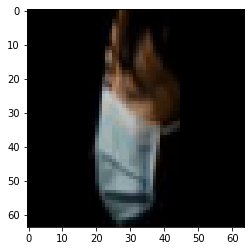

In [15]:
err = (2,1)
err_ind= []

for ind in range(len(err_ind_list)):
    if err_ind_list[ind][1] == err:
        err_ind.append(err_ind_list[ind][0])

ind_image = err_ind[0]
plt.imshow(test_images[ind_image])
print('pred=',pred[ind_image])
print('real=',test_labels[ind_image][0])
#print('Counter(data)\n',Counter(err_ind))

In [23]:
import pandas as pd
sheet=pd.read_excel('YOLO_Errors.xlsx')
yolo_err=sheet.values

In [96]:
out2 = []
err_group_yolo = []
name1 = yolo_err[0][0]
for er in yolo_err:
    name2 = er[0]
    if type(er[0]) == float:
        name2 = name1
    if type(er[1]) == float:
        out2.append([name2,er[1],er[2][0],er[2]])
    elif type(er[2]) == float:
        out2.append([name2,er[1][0],'nan','nan'])
    elif er[1][0]!=er[2][0]:
        out2.append([name2,er[1][0],er[2][0],er[2]])
        err_group_yolo.append((er[1][0],er[2][0]))
    name1=name2
    
frame = pd.DataFrame(np.array(out2),columns=['file','Model','label','bbox'])
frame.to_excel('Yolo_err_proc.xlsx')

In [97]:
print('Counter(data)\n',Counter(err_group_yolo))

Counter(data)
 Counter({('1', '3'): 10, ('3', '1'): 10, ('4', '2'): 9, ('3', '4'): 7, ('1', '2'): 5, ('0', '2'): 5, ('4', '3'): 4, ('0', '3'): 3, ('2', '1'): 2, ('2', '5'): 2, ('0', '4'): 2, ('2', '4'): 2, ('0', '1'): 2, ('1', '0'): 2, ('5', '3'): 1, ('4', '0'): 1, ('3', '0'): 1})


In [98]:
len(err_group_yolo)

68

In [89]:
a='we'
b=a
print(b)
b='sdf'
print(a)
a=b
print(a)


we
we
sdf


In [ ]:
测试数据集一共375，

六大类别（没有group）的结果：
1. 六个类别分别对应的图片数量分布如下：{3: 113, 1: 91, 0: 75, 4: 42, 2: 34, 5: 20}
2. 错误数33，即错误率8.8%，准确率91.2%;
3. 识别错误的统计信息如下：
（预测:实际）{(1, 3): 9, (2, 4): 3, (5, 0): 2, (2, 1): 2, (2, 0): 2, (2, 3): 2, (3, 2): 2, (3, 0): 1, (4, 1): 1, (0, 2): 1, (4, 2): 1, (4, 5): 1, (4, 3): 1, (5, 1): 1, (1, 0): 1, (5, 4): 1, (3, 4): 1, (4, 0): 1}
也就是说（1,3）(2,4)容易混淆，这个比较合理

如果group，结果如下：
1. 变成四个类别，对应的图片数量分布如下：{1: 204, 2: 76, 0: 75, 3: 20}
2. 错误数20，即错误率5.3%，准确率94.6%;
3. 识别错误的统计信息如下：{(1, 2): 9, (1, 0): 3, (1, 3): 3, (2, 1): 2, (0, 3): 1, (2, 3): 1, (3, 2): 1}
错误率最高的是（1，2）即fully 和 partial不好区别
